# CAFE60_ETBF_doc_test_export

**Date:** <br>
19 March 2022 <br>
**Background:** <br>
Issue -  <br>
**Author(s):**<br>
Thomas Moore<br>

### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

## OOD cluster

In [4]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="12GB",walltime='03:00:00')
client = Client(cluster)
cluster.scale(cores=12)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [6]:
client

<Client: 'tcp://10.0.128.132:33349' processes=9 threads=9, memory=100.62 GiB>

# load final ETBF CAFE60 1grid collections from zarr

In [7]:
%%time
ds = xr.open_zarr('/g/data/xv83/users/tm4888/data/CAFE/CAFE60_1deg_ETBFvar.zarr/',consolidated=True)

CPU times: user 125 ms, sys: 17.1 ms, total: 142 ms
Wall time: 209 ms


# Tests $\Downarrow$

In [7]:
# Test for zeroes
for varname, da in ds.data_vars.items():
    if (ds[varname] == 0).any():
        raise ValueError(varname + " variable has a zero value <<<")
    else:
        print('No zero values found in '+varname)

No zero values found in D20
No zero values found in eke2000
No zero values found in eke300
No zero values found in hc200
No zero values found in hc300
No zero values found in mld
No zero values found in sss
No zero values found in sst
No zero values found in temp100
No zero values found in temp200
No zero values found in temp50
No zero values found in temp500
No zero values found in u100
No zero values found in u100_300
No zero values found in v100
No zero values found in v100_300


In [8]:
# Test for negative values
for varname, da in ds.data_vars.items():
    if (ds[varname] < 0).any():
        print(varname + " variable has negative values <<<")
    else:
        print('No negative values found in '+varname)

No negative values found in D20
No negative values found in eke2000
No negative values found in eke300
hc200 variable has negative values <<<
hc300 variable has negative values <<<
No negative values found in mld
No negative values found in sss
sst variable has negative values <<<
temp100 variable has negative values <<<
temp200 variable has negative values <<<
temp50 variable has negative values <<<
temp500 variable has negative values <<<
u100 variable has negative values <<<
u100_300 variable has negative values <<<
v100 variable has negative values <<<
v100_300 variable has negative values <<<


# Tests $\Uparrow$

In [8]:
ds

<xarray.Dataset>
Dimensions:   (time: 250, lat: 180, lon: 360)
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time      (time) object 2000-01-16 12:00:00 ... 2020-10-16 12:00:00
Data variables: (12/16)
    D20       (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    eke2000   (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    eke300    (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    hc200     (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    hc300     (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    mld       (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ...        ...
    temp50    (time, lat, lon) float32 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    temp500   (time, lat, lon) float32 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    u100      (time, lat, lon) float32 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    u100_300  (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    v100      (time, lat, lon) float32 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    v100_300  (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# harmonise hours & change time format

In [9]:
cf_time_index = xr.CFTimeIndex(ds.time.values)
index_date_strings = cf_time_index.strftime('%Y-%m-%d')
new_datetime = pd.to_datetime(index_date_strings)
ds['time'] = new_datetime

# metadata
#### Sadly, despite settings to the contrary, namely `xr.set_options.keep_attrs({True})` xESMF appears to strip away all metadata.  So we need to replace here.

In [10]:
timestamp = datetime.today().strftime('%Y-%m-%d')
history_string = 'File written by thomas.moore@csiro.au on ' + timestamp + ' using workflow https://github.com/Thomas-Moore-Creative/NCI-CAFE-ARD'

In [11]:
#global
ds.attrs = {'regrid_method':'xESMF - bilnear with land mask',
           'product' : 'CSIRO CAFE60 reanalysis',
           'product URL': 'https://research.csiro.au/dfp/cafe-csiro-decadal-prediction-system/',
           'contact':'thomas.moore@csiro.au',
           'History':history_string}
#coordinates
ds['lat'].attrs = {'long_name':'latitude','units':'degrees'}
ds['lon'].attrs = {'long_name':'longitude','units':'degrees'}
#ds['time'].attrs = {'long_name':'timestamp','units':'month'}
#variables
ds['D20'].attrs = {'long_name':'Depth of 20C isotherm','units':'m'}
ds['eke2000'].attrs = {'long_name':'eke depth weighted sum 0-2000m'}
ds['eke300'].attrs = {'long_name':'eke depth weighted sum 0-300m'}
ds['hc300'].attrs = {'long_name':'Heat content 300 m','units':'J/m2'}
ds['hc200'].attrs = {'long_name':'Heat content 200 m','units':'J/m2'}
ds['mld'].attrs = {'long_name':'Mixed Layer Depth','units':'m'}
ds['sss'].attrs = {'long_name':'Sea Surface Salinity','units':'PSU'}
ds['sst'].attrs = {'long_name':'Sea Surface Temperature','units':'degC'}
ds['temp50'].attrs = {'long_name':'Seawater Potential Temperature at 50m','units':'degC'}
ds['temp100'].attrs = {'long_name':'Seawater Potential Temperature at 100m','units':'degC'}
ds['temp200'].attrs = {'long_name':'Seawater Potential Temperature at 200m','units':'degC'}
ds['temp500'].attrs = {'long_name':'Seawater Potential Temperature at 500m','units':'degC'}
ds['u100'].attrs = {'long_name':'x velocity at 100m','units':'m/s'}
ds['v100'].attrs = {'long_name':'y velocity at 100m','units':'m/s'}
ds['u100_300'].attrs = {'long_name':'x velocity depth weighted mean between 100-300m','units':'m/s'}
ds['v100_300'].attrs = {'long_name':'y velocity depth weighted mean between 100-300m','units':'m/s'}
ds

<xarray.Dataset>
Dimensions:   (time: 250, lat: 180, lon: 360)
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time      (time) datetime64[ns] 2000-01-16 2000-02-15 ... 2020-10-16
Data variables: (12/16)
    D20       (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    eke2000   (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    eke300    (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    hc200     (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    hc300     (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    mld       (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ...        ...
    temp50    (time, lat, lon) float32 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    temp500   (time, lat, lon) float32 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    u100      (time, lat, lon) float32 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    u100_300  (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    v100      (time, lat, lon) float32 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
    v100_300  (time, lat, lon) float64 dask.array<chunksize=(250, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  xESMF - bilnear with land mask
    product:        CSIRO CAFE60 reanalysis
    product URL:    https://research.csiro.au/dfp/cafe-csiro-decadal-predicti...
    contact:        thomas.moore@csiro.au
    History:        File written by thomas.moore@csiro.au on 2022-03-20 using...

# Write out single NC file

In [12]:
%%time
ds.to_netcdf('/g/data/xv83/users/tm4888/data/CAFE/CAFE60.ETBFvars.grid1deg.nc')

CPU times: user 3.51 s, sys: 814 ms, total: 4.32 s
Wall time: 27.2 s


# TEST final NC file
# $\Downarrow$

In [13]:
final_ds = xr.open_dataset('/g/data/xv83/users/tm4888/data/CAFE/CAFE60.ETBFvars.grid1deg.nc')

In [14]:
test_ds = final_ds.isel(time=100).compute()

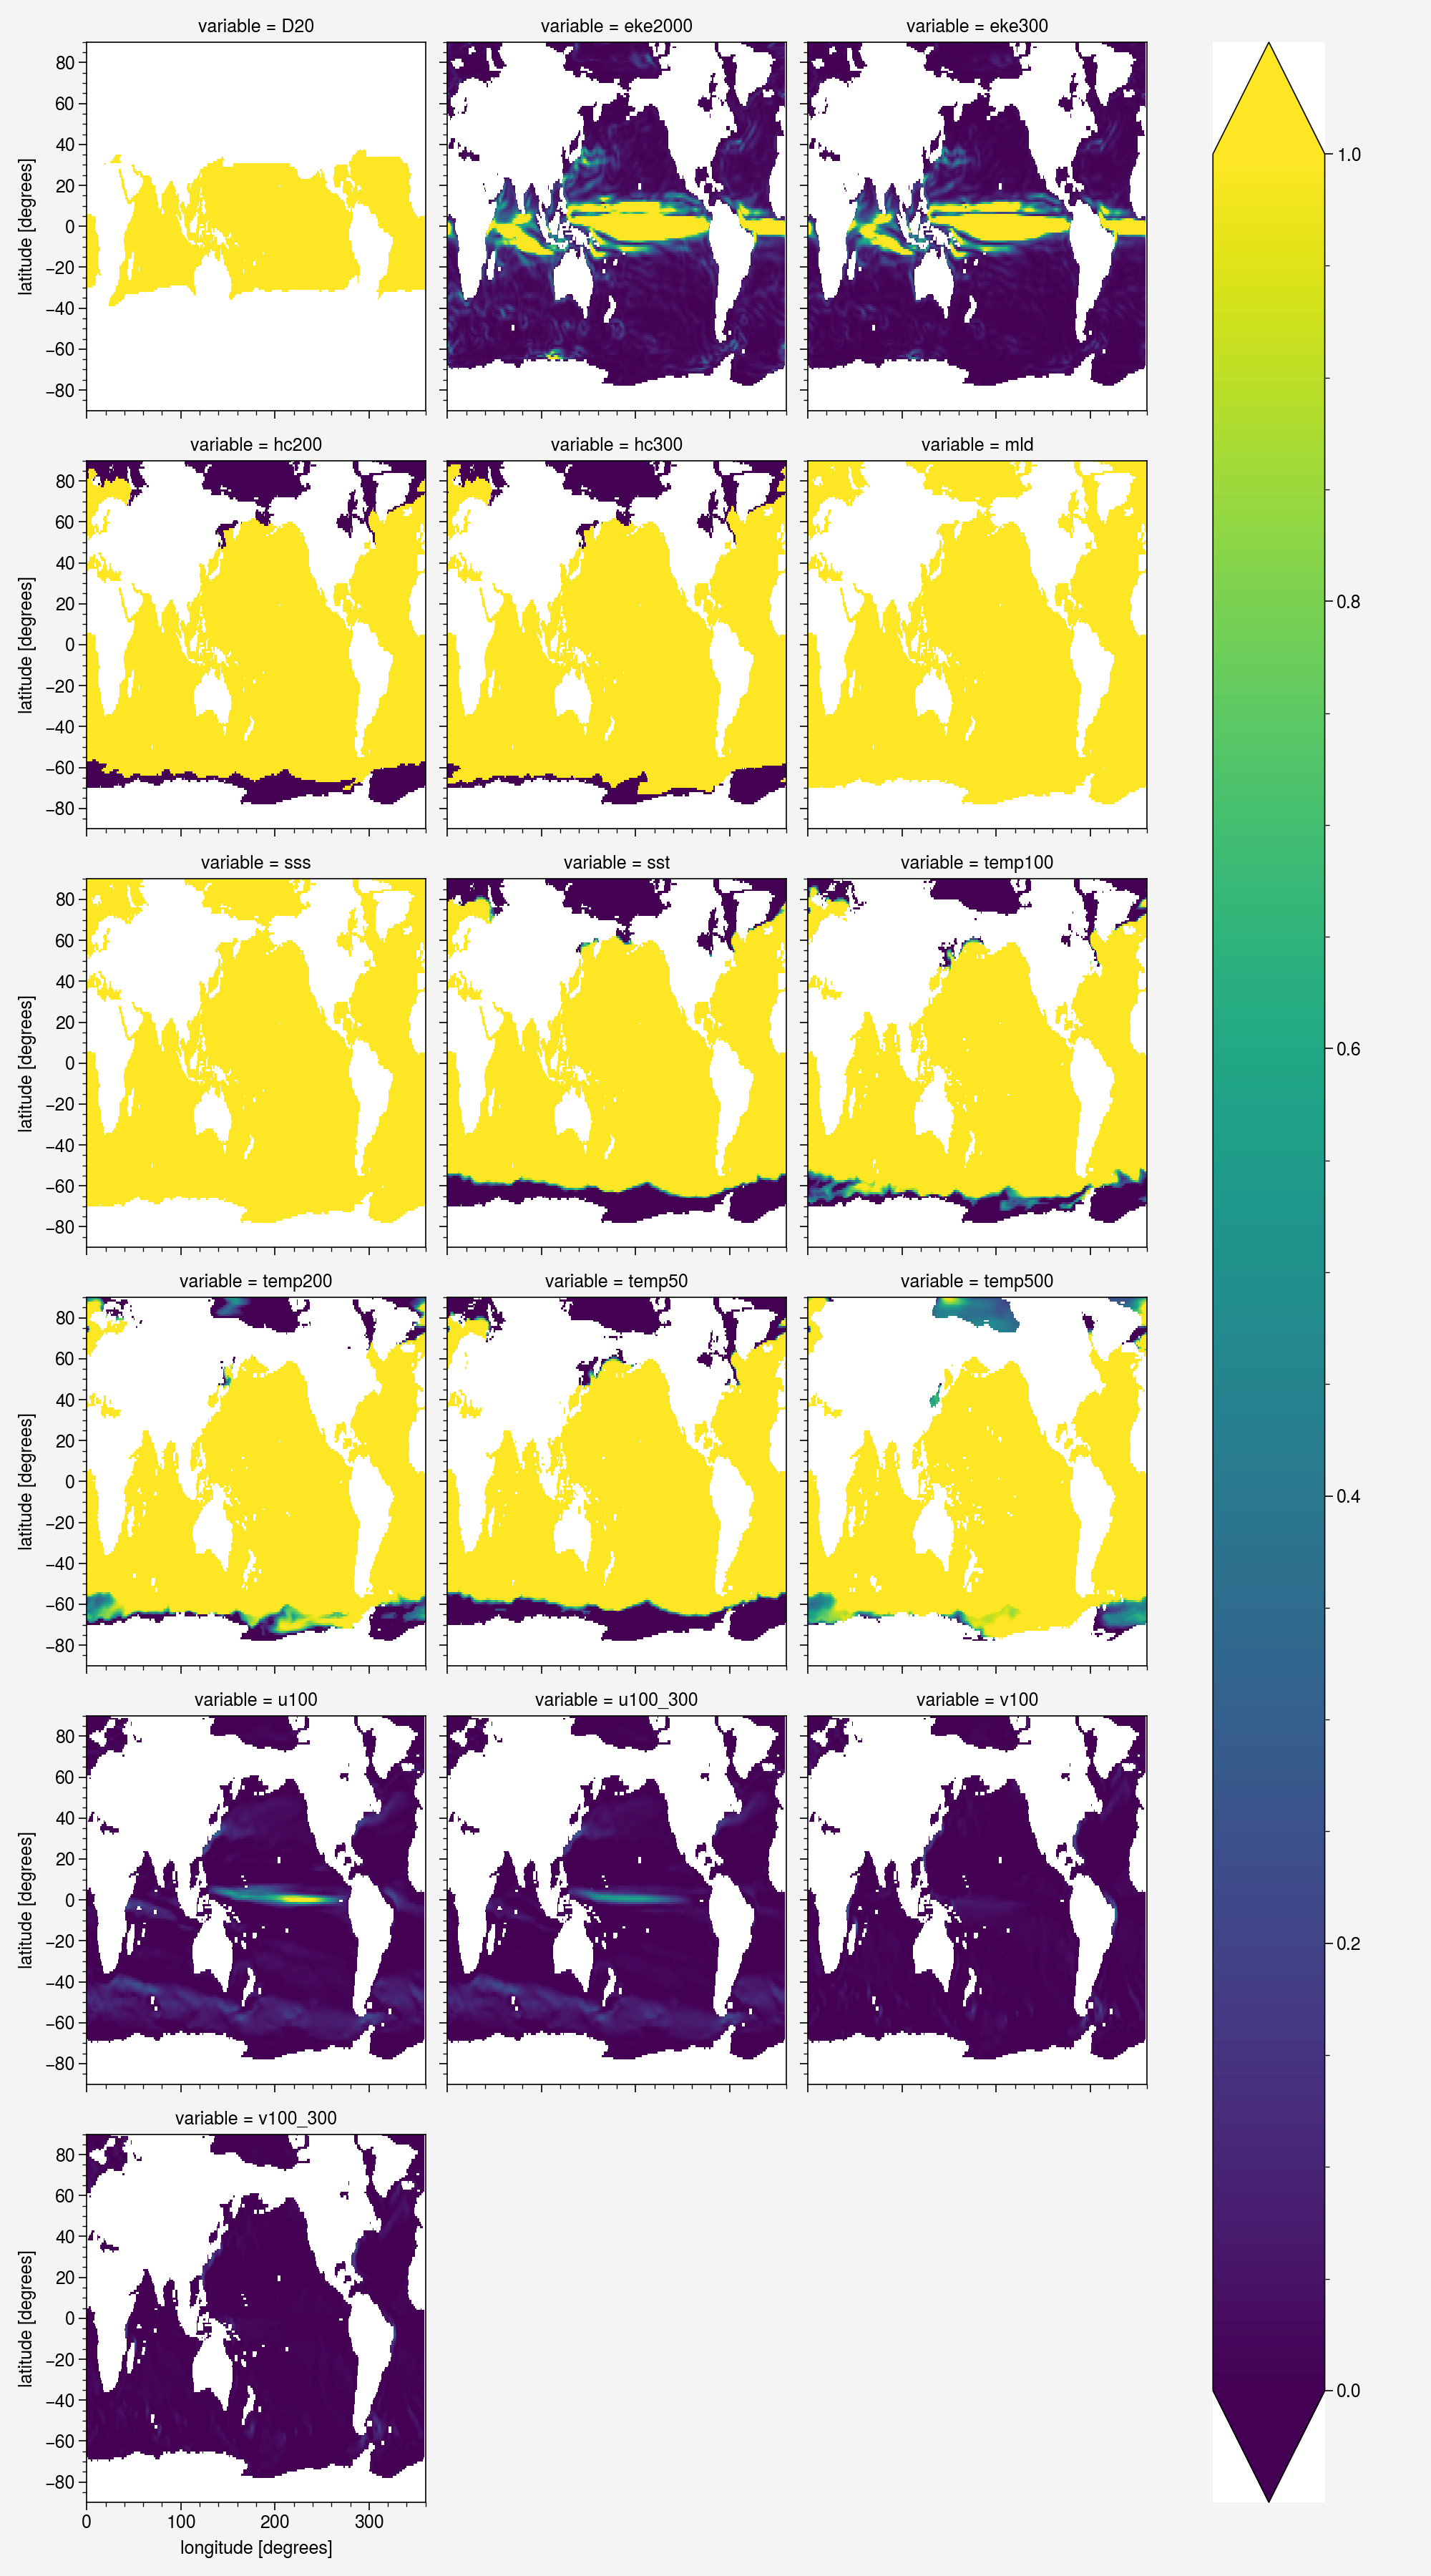

In [15]:
test_ds.to_array().plot(col = 'variable',col_wrap=3,robust=True,vmin = 0,vmax= 1.0)

## do mean temperatures make sense?

In [18]:
sst_mean = test_ds.sst.mean()
temp50_mean = test_ds.temp50.mean()
temp100_mean = test_ds.temp100.mean()
temp200_mean = test_ds.temp200.mean()
temp500_mean = test_ds.temp500.mean()
print(sst_mean,temp50_mean.values,temp100_mean.values,temp200_mean.values,temp500_mean.values)

<xarray.DataArray 'sst' ()>
array(14.566882, dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-05-16 13.85245 12.392816 10.263696 6.331106


# does eke make sense?

In [19]:
eke300_mean = test_ds.eke300.mean()
eke2000_mean = test_ds.eke2000.mean()
print(eke300_mean.values,eke2000_mean.values)

0.39314591857213405 0.4920299416637114


In [20]:
eke300_max = test_ds.eke300.max()
eke2000_max = test_ds.eke2000.max()
print(eke300_max.values,eke2000_max.values)

24.351036345876942 28.08975050104176


# does HC make sense?

In [21]:
hc200_mean = test_ds.hc200.mean()
hc300_mean = test_ds.hc300.mean()
print(hc200_mean.values,hc300_mean.values)

9428671912.695126 13183600942.00506


# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

In [22]:
client.shutdown()

In [ ]:
client.restart()